# Use Amazon Comprehend Medical and Rekognition to help de-identify medical images

Medical images are a foundational tool in modern medicine that enable clinicians to visualize critical information about a patient to help diagnosis and treat them.  The digitization of medical images has vastly improved our ability to reliably store, share, view, search, and currate these images to best enable our medical professionals.  The variety of modalities of these images has also increased.  From CT scans to MRIs, digital pathology to ultrasounds, there is a vast amount of information collected in the archives of digital medical images that have been captured.

These medical images are also useful for medical research.  Using machine learning our global medical research institutions are now pressing forward into insights that can only be gained by analyzing hundreds of thousands or millions or images.  Doing this and respecting a patients right to privacy provided by regulation like the Health Information Portability and Accountability Act (HIPAA) can be challenging.  Often, these medical images contain Protected Health Information (PHI) stored as text within the image itself.  This has historically presented a challenge because removing this PHI required manual review of the image and editing.  This process can easily add up to many minutes per image and makes de-identifying large medical image datasets expensive and time consuming.

Last year Amazon announced the ability to easily detect and exract text from images using our machine learning service [Amazon Rekognition](https://aws.amazon.com/about-aws/whats-new/2017/11/amazon-rekognition-announces-real-time-face-recognition-text-in-image-recognition-and-improved-face-detection/ "Amazon Rekognition").  This year we annouced a new machine learning NLP service for medical text called Comprehend Medical that can help customers to detect PHI with a string of text.  Combining these two services together with some Python code, as demonstrated following, can help customers inexpensively and quickly redact PHI from within medical images.

## De-identification architecture

In this example, we will use the Notebooks feature of Amazon SageMaker to create an interactive notebook with Python code.  These notebooks are just one part of Amazon SageMaker, a fully-managed service that covers the entire machine learning workflow to label and prepare your data, choose an algorithm, train the algorithm, tune and optimize it for deployment, make predictions, and take action.  In this instance though, for the actual machine learning and predition, we will be using Amazon Rekognition to extract text from the images and Amazon Comprehend Medical to help us identify the PHI.  All of our images files will be read from and written to a bucket in Amazon Simple Storage Service (Amazon S3), an object storage service that offers industry-leading scalability, data availability, security, and performance.

Running this within a SageMaker notebook provides the best environment for us to understand the process used here and see the results.  However, if you wanted to batch process thousands or millions of images, this same code could be implemented using AWS Lambda or AWS Batch.  You could even associate a Lambda function containing this code with an Amazon S3 bucket so that every time a new image is added it would automatically be de-identified and written to another bucket.

![alt-text](de-identify-medical-images-blog-post.png "diagram")

When using Amazon Comprehend Medical to identify protected health information, please recall that the service provides confidence scores that indicate the level of confidence in the accuracy of the detected entities. You should evaluate these confidence scores and identify the right confidence threshold for your use case. For specific compliance use cases, we recommend you use additional human review or other methods to confirm the accuracy of detected PHI.

Under the HIPAA act, PHI that is based on a list of 18 identifiers must be treated with special care. These identifiers consist of data that can be used to identify an individual patient, including the following list. For more information, see Health Information Privacy on the U.S. Government Health and Human Services Web site.

When working with PHI, it is important to understand that while Comprehend Medical detects entities associated with these identifiers from clinical text, these entities don't map 1:1 to the above list of 18 specified by the Safe Harbor rule. Not all identifiers are contained in unstructured clinical text, but Comprehend Medical does cover the relevant identifiers.

Each PHI-related entity includes a score (Score in the response) that indicates the level of confidence Amazon Comprehend Medical has in the accuracy of the detection. You should identify the right confidence threshold for your use case and filter out entities that do not meet it. In certain compliance use cases where you are identifying occurrences of PHI rather than using the values of the detected entities, it may be better to use a low confidence threshold for filtering because you will capture more potential occurrences.

## Using the notebook

At the very begining of the code you will see 5 parameters that we can set to control the de-identification process.  In order to process your images, they must be in either PNG or JPG formats.  If you are starting with an image in DICOM format (.dcm) then you can use utilities like [dcmj2pnm](https://support.dcmtk.org/docs/dcmj2pnm.html) or [ImageMagick](http://imagemagick.sourceforge.net/http/www/formats.html) can be used to convert them to PNG or JPG.  
* **bucket** defines the S3 bucket where your identified images are stored.  This is also the bucket that the deidentified images will be written to.
* **object** defines the identified image that you want to de-identify.  These can be PNG or JPG images.
* **phi_detection_threshold** is the threshold for the confidence score mentioned above.  Text analyze by Comprehend Medical must meet this minimum score to be redacted from the output image.  Raising this score will reduce PHI false positives and more information will be redacted.  Lowering this score will result in fewer false positives, but it is possible that some PHI won't be redacted.
* **redacted_box_color** defines the color that will be used to cover up PHI text within the image.
* **dpi** defines the dpi setting that will be used in the output image




In [ ]:
#ImageMagick is used to convert DICOM images to PNG if the image extension ends with .dcm
#If ImageMagick is not installed, install it.
! sudo yum install -y ImageMagick

download: s3://de-id-xrays/test/00000001_001-id.dcm to ./00000001_001-id.dcm
upload: ./00000001_001-id.dcm.png to s3://de-id-xrays/test/00000001_001-id.dcm.png
test/00000001_001-id.dcm.png


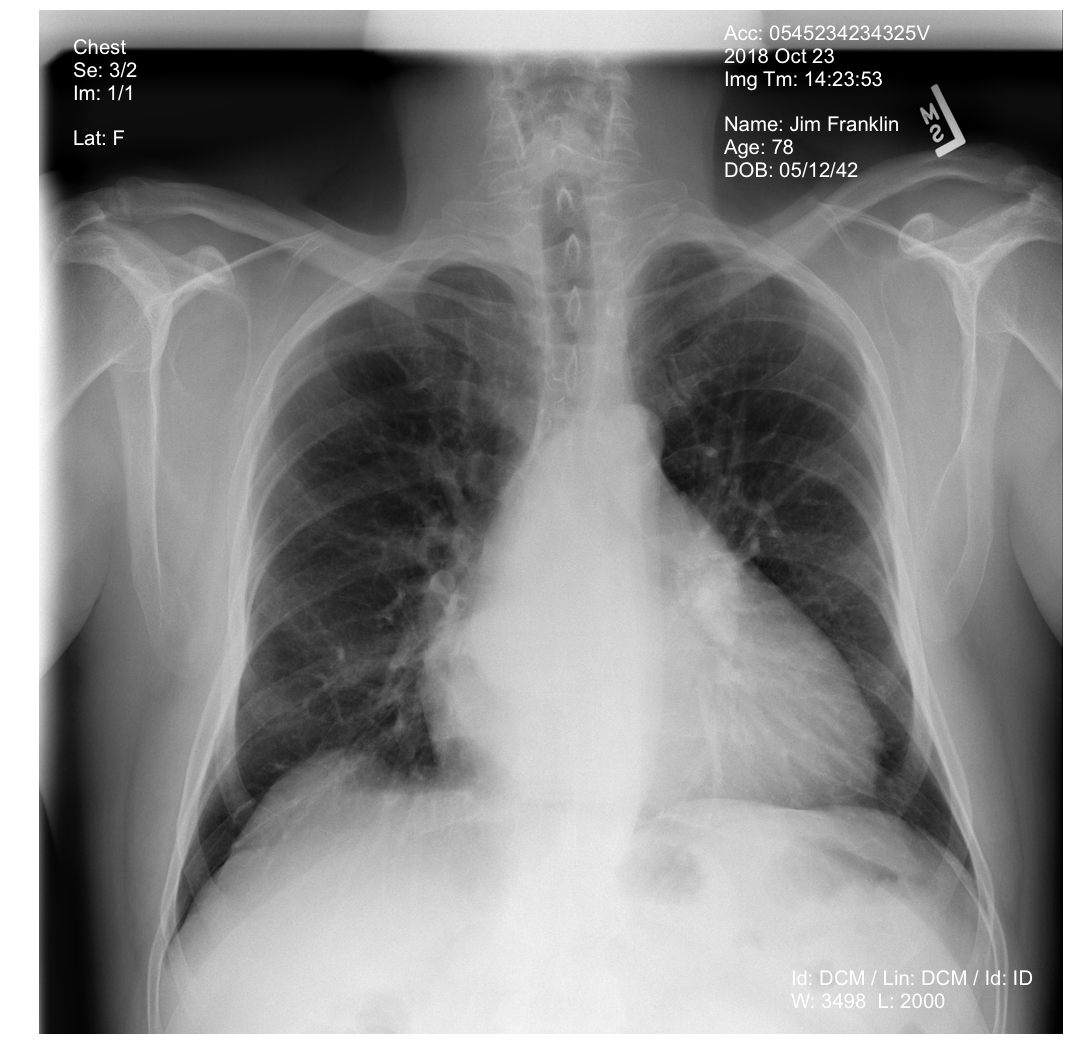

In [85]:
#Define the S3 bucket and object for the medical image we want to analyze.  Also define the color used for redaction.
bucket='yourbucket'
object='yourimages.dcm'
redacted_box_color='red'
dpi = 72
phi_detection_threshold = 0.00


#If the image is in DICOM format, convert it to PNG
if (object.split(".")[-1:][0] == "dcm"):
    ! aws s3 cp s3://{bucket}/{object} .
    ! mogrify -format png {object.split("/")[-1:][0]} {object.split("/")[-1:][0]}.png
    ! aws s3 cp {object.split("/")[-1:][0]}.png s3://{bucket}/{object}.png
    object=object+'.png'
    print(object)

#Import all of the required libraries
%matplotlib inline
import boto3
import json
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import matplotlib as mpl
from imageio import imread

#Implement AWS Services
rekognition=boto3.client('rekognition')
comprehendmedical = boto3.client(service_name='comprehendmedical')
s3=boto3.resource('s3')

#Download the image from S3 and hold it in memory
img_bucket = s3.Bucket(bucket)
img_object = img_bucket.Object(object)
xray = io.BytesIO()
img_object.download_fileobj(xray)
img = np.array(Image.open(xray), dtype=np.uint8)

#Set the image color map to grayscale, turn off axis graphing, and display the image
height, width = img.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)
# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
# Hide spines, ticks, etc.
ax.axis('off')
# Display the image.
ax.imshow(img, cmap='gray')
plt.show()

In [86]:
#Use Amazon Rekognition to detect all of the text in the medical image
response=rekognition.detect_text(Image={'S3Object':{'Bucket':bucket,'Name':object}})
textDetections=response['TextDetections']
print 'Aggregating detected text...'
textblock=""
offsetarray=[]
totallength=0

#The various text detections are returned in a JSON object.  Aggregate the text into a single large block and
#keep track of the offsets.  This will allow us to make a single call to Amazon Comprehend Medical for
#PHI detection and minimize our Comprehend Medical service charges.
for text in textDetections:
    if text['Type'] == "LINE":
            offsetarray.append(totallength)
            totallength+=len(text['DetectedText'])+1
            textblock=textblock+text['DetectedText']+" "  
            print "adding '"+text['DetectedText']+"', length: "+str(len(text['DetectedText']))+", offsetarray: "+str(offsetarray)
offsetarray.append(totallength)
totaloffsets=len(offsetarray)

Aggregating detected text...
adding 'Acc: 0545234234325V', length: 19, offsetarray: [0]
adding 'Chest', length: 5, offsetarray: [0, 20]
adding '2018 Oct 23', length: 11, offsetarray: [0, 20, 26]
adding 'Se: 3/2', length: 7, offsetarray: [0, 20, 26, 38]
adding 'Img Tm: 14:23:53', length: 16, offsetarray: [0, 20, 26, 38, 46]
adding 'Im: 1/1', length: 7, offsetarray: [0, 20, 26, 38, 46, 63]
adding 'Name: Jim Franklin', length: 18, offsetarray: [0, 20, 26, 38, 46, 63, 71]
adding 'Lat: F', length: 6, offsetarray: [0, 20, 26, 38, 46, 63, 71, 90]
adding 'Age: 78', length: 7, offsetarray: [0, 20, 26, 38, 46, 63, 71, 90, 97]
adding 'DOB: 05/12/42', length: 13, offsetarray: [0, 20, 26, 38, 46, 63, 71, 90, 97, 105]
adding 'Id: DCM/ Lin: DCM/Id: ID', length: 24, offsetarray: [0, 20, 26, 38, 46, 63, 71, 90, 97, 105, 119]
adding 'W: 3498 L: 2000', length: 15, offsetarray: [0, 20, 26, 38, 46, 63, 71, 90, 97, 105, 119, 144]


In [87]:
#Call Amazon Comprehend Medical and pass it the aggregated text from our medical image.
phi_boxes_list=[]
philist=comprehendmedical.detect_phi(Text = textblock)

#Amazon Comprehend Medical will return a JSON object that contains all of the PHI detected in the text block with
#offset values that describe where the PHI begins and ends.  We can use this to determine which of the text blocks 
#detected by Amazon Rekognition should be redacted.  The 'phi_boxes_list' list is created to keep track of the
#bounding boxes that potentially contain PHI.
print 'Finding PHI text...'
not_redacted=0
for phi in philist['Entities']:
    if phi['Score'] > phi_detection_threshold:
        for i in range(0,totaloffsets-1):
            if offsetarray[i] <= phi['BeginOffset'] < offsetarray[i+1]:
                if textDetections[i]['Geometry']['BoundingBox'] not in phi_boxes_list:
                    print "'"+phi['Text']+"' was detected as type '"+phi['Type']+"' and will be redacted."
                    phi_boxes_list.append(textDetections[i]['Geometry']['BoundingBox'])
    else:
        print "'"+phi['Text']+"' was detected as type '"+phi['Type']+"', but did not meet the confidence score threshold and will not be redacted."
        not_redacted+=1
print "Found", len(phi_boxes_list), "text boxes to redact."
print not_redacted, "additional text boxes were detected, but did not meet the confidence score threshold."

Finding PHI text...
'0545234234325V' was detected as type 'ID' and will be redacted.
'2018' was detected as type 'DATE' and will be redacted.
'3/2' was detected as type 'DATE' and will be redacted.
'1/1' was detected as type 'DATE' and will be redacted.
'Jim Franklin' was detected as type 'NAME' and will be redacted.
'78' was detected as type 'AGE' and will be redacted.
'05/12/42' was detected as type 'DATE' and will be redacted.
'2000' was detected as type 'DATE' and will be redacted.
Found 8 text boxes to redact.
0 additional text boxes were detected, but did not meet the confidence score threshold.


s3.Object(bucket_name='de-id-xrays', key='de-id-test/00000001_001-id.dcm.png')

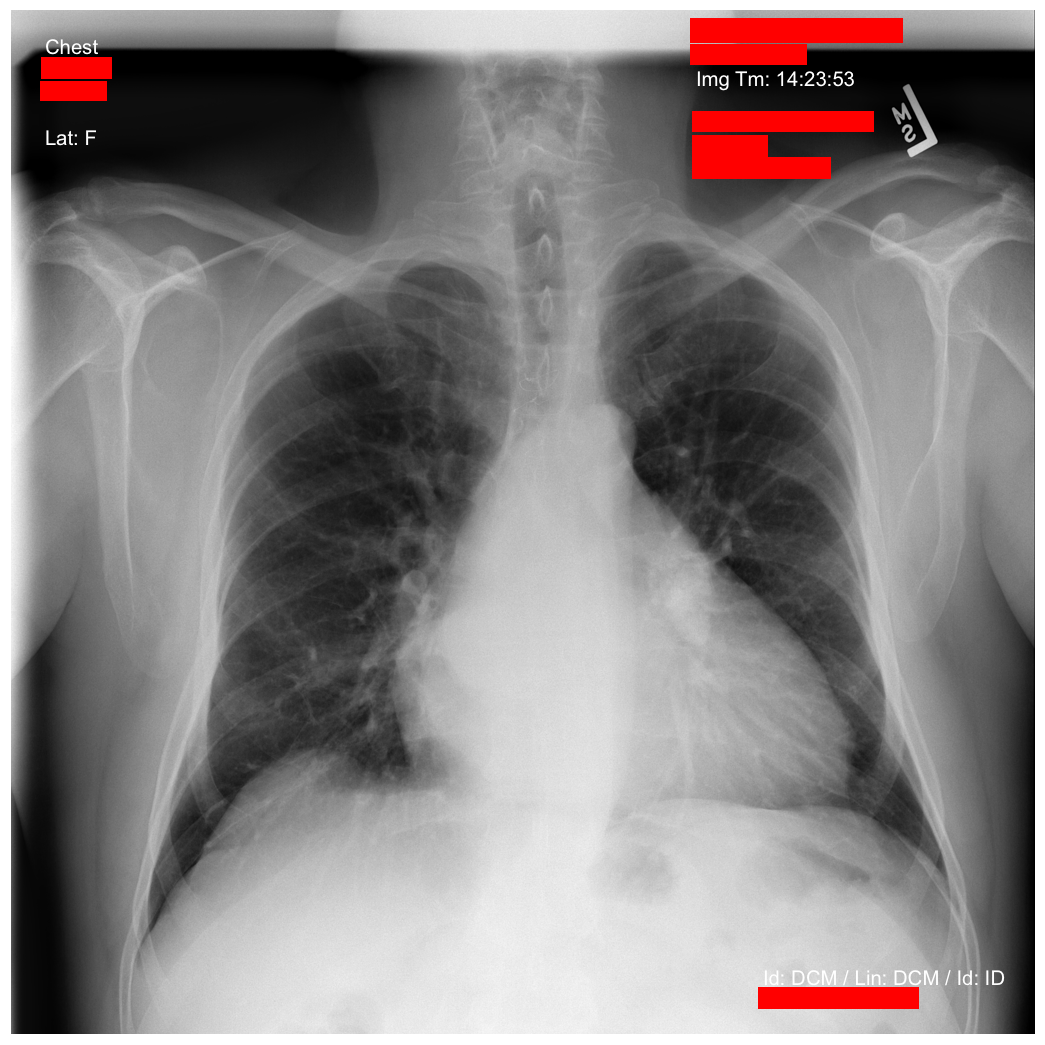

In [88]:
#Now this list of bounding boxes will be used to draw red boxes over the PHI text.
height, width = img.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)
# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(img)
plt.imshow(img, cmap='gray')
for box in phi_boxes_list:
    #The bounding boxes are described as a ratio of the overall image dimensions, so we must multiply them
    #by the total image dimensions to get the exact pixel values for each dimension.
    x = img.shape[0] * box['Left']
    y = img.shape[1] * box['Top']
    width = img.shape[0] * box['Width']
    height = img.shape[1] * box['Height']
    rect = patches.Rectangle((x,y),width,height,linewidth=0,edgecolor=redacted_box_color,facecolor=redacted_box_color)
    ax.add_patch(rect)
#Ensure that no axis or whitespaces is printed in the image file we want to save.
plt.axis('off')    
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

#Save redacted medical image to the same Amazon S3 bucket, in PNG format, with 'de-id-' in front of the original
#filename.
img_data = io.BytesIO()
plt.savefig(img_data, bbox_inches='tight', pad_inches=0, format='png')
img_data.seek(0)
img_bucket.put_object(Body=img_data, ContentType='image/png', Key='de-id-'+object)